In [44]:
import pandas as pd
df = pd.read_csv("../Resources/collision_geo_data_clean.csv", dtype = {'zip_code':'object'})

with open('../api_keys/openweather.txt', 'r') as file:
    weather_apikey = file.readline().strip()

with open('../api_keys/geoapify.txt', 'r') as file:
    geo_apikey = file.readline().strip()


In [45]:
geo_apikey

'e1b4bf97773d4a7eabe0120e069b0d6f'

In [20]:
grouped = df.groupby(['crash_date','zip_code']).size()
grouped

crash_date  zip_code
2016-04-16  11214       1
2019-05-21  11201       1
2020-01-21  10454       1
2020-04-15  11231       1
2021-02-26  10461       1
                       ..
2022-04-24  11419       1
            11435       1
2022-06-29  10465       1
            11211       1
2022-07-12  11225       1
Length: 736, dtype: int64

In [37]:
grouped_df = pd.DataFrame(grouped).reset_index()
grouped_df = grouped_df.iloc[:, :-1]
grouped_df.reset_index(drop=True, inplace=True)

import pandas as pd
from datetime import datetime
grouped_df['crash_date'] = pd.to_datetime(grouped_df['crash_date'])
grouped_df['unix_timestamp'] = grouped_df['crash_date'].apply(lambda x: int(x.timestamp()))

grouped_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   crash_date      736 non-null    datetime64[ns]
 1   zip_code        736 non-null    object        
 2   unix_timestamp  736 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.4+ KB


In [71]:
grouped_df

,crash_date,zip_code,unix_timestamp,lat,lon
0,2016-04-16,11214,1460764800,40.602073,-73.996609
1,2019-05-21,11201,1558396800,40.692586,-73.991739
2,2020-01-21,10454,1579564800,40.807720,-73.918203
3,2020-04-15,11231,1586908800,40.680212,-74.000387
4,2021-02-26,10461,1614297600,40.845849,-73.841081
...,...,...,...,...,...
731,2022-04-24,11419,1650758400,40.688207,-73.823425
732,2022-04-24,11435,1650758400,40.699627,-73.808419
733,2022-06-29,10465,1656460800,40.826514,-73.818515
734,2022-06-29,11211,1656460800,40.725312,-73.946489


In [36]:
unique_values = grouped.index.get_level_values('zip_code').unique()
unique_values

Index(['11214', '11201', '10454', '11231', '10461', '11205', '11385', '11221',
       '11234', '10016',
       ...
       '10028', '10038', '10168', '11361', '11375', '11421', '11430', '10280',
       '10044', '10462'],
      dtype='object', name='zip_code', length=170)

In [41]:
# extract the center coordinates of each zip code
import requests
geo_data_all = []

for zip in grouped_df['zip_code'].unique():
    url = f"https://api.geoapify.com/v1/geocode/search?text={zip}&lang=en&limit=10&type=postcode&filter=countrycode:us&apiKey={geo_apikey}"
    geoapify = requests.get(url)
    geo_data = geoapify.json()

    geo_data_all.append(geo_data)

In [48]:
import pandas as pd

# Create a dictionary to map zip codes to latitudes and longitudes
zip_code_mapping = {entry['features'][0]['properties']['postcode']: {
    'lat': entry['features'][0]['properties']['lat'],
    'lon': entry['features'][0]['properties']['lon']
} for entry in geo_data_all}

# Add latitude and longitude columns to the DataFrame
grouped_df['lat'] = grouped_df['zip_code'].map(lambda x: zip_code_mapping[x]['lat'] if x in zip_code_mapping else None)
grouped_df['lon'] = grouped_df['zip_code'].map(lambda x: zip_code_mapping[x]['lon'] if x in zip_code_mapping else None)

# Display the updated DataFrame
print(grouped_df)


    crash_date zip_code  unix_timestamp        lat        lon
0   2016-04-16    11214      1460764800  40.602073 -73.996609
1   2019-05-21    11201      1558396800  40.692586 -73.991739
2   2020-01-21    10454      1579564800  40.807720 -73.918203
3   2020-04-15    11231      1586908800  40.680212 -74.000387
4   2021-02-26    10461      1614297600  40.845849 -73.841081
..         ...      ...             ...        ...        ...
731 2022-04-24    11419      1650758400  40.688207 -73.823425
732 2022-04-24    11435      1650758400  40.699627 -73.808419
733 2022-06-29    10465      1656460800  40.826514 -73.818515
734 2022-06-29    11211      1656460800  40.725312 -73.946489
735 2022-07-12    11225      1657584000  40.662443 -73.953075

[736 rows x 5 columns]


In [121]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   crash_date      736 non-null    datetime64[ns]
 1   zip_code        736 non-null    object        
 2   unix_timestamp  736 non-null    int64         
 3   lat             736 non-null    float64       
 4   lon             736 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 28.9+ KB


In [272]:
weather_first4rows_df = pd.read_csv("../Resources/past_weather_ny0.csv")
weather_first4rows_df['datetime'] = pd.to_datetime(weather_first4rows_df['datetime'])
weather_remaining_df = pd.read_csv("../Resources/past_weather_ny.csv")
weather_remaining_df['datetime'] = pd.to_datetime(weather_remaining_df['datetime'])
weather_df = pd.concat([weather_first4rows_df, weather_remaining_df], ignore_index=True)
weather_df.head()



,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York, NY",2016-04-16,65.4,44.3,53.3,65.4,40.7,52.5,26.4,40.6,...,27.1,10,NaN,2016-04-16T06:14:57,2016-04-16T19:37:05,0.31,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KLGA,KNYC,72503014732"
1,"New York, NY",2019-05-21,23.7,14.3,19.0,23.7,14.3,19.0,5.9,43.6,...,28.0,9,NaN,2019-05-21T05:34:00,2019-05-21T20:11:47,0.59,Rain,Clear conditions throughout the day with after...,rain,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."
2,"New York, NY",2020-01-21,3.1,-4.5,-1.6,-0.1,-9.0,-4.7,-9.9,54.3,...,9.9,5,NaN,2020-01-21T07:15:10,2020-01-21T16:59:42,0.89,Clear,Clear conditions throughout the day.,clear-day,"D9152,72505394728,72055399999,KLGA,DEAN4,KJRB,..."
3,"New York, NY",2020-04-15,12.7,6.1,9.5,12.7,3.8,8.5,-3.7,41.9,...,24.0,10,NaN,2020-04-15T06:16:27,2020-04-15T19:36:05,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."
4,"New York, NY",2021-02-26,45.0,35.0,40.1,41.1,30.8,35.6,20.8,46.4,...,14.9,7,NaN,2021-02-26T06:34:03,2021-02-26T17:44:15,0.48,Clear,Clear conditions throughout the day.,clear-day,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."


In [273]:
# only keeping the weather info for dates that are also in grouped_df['crash_date']
overlapping_dates = weather_df['datetime'].isin(grouped_df['crash_date'])
filtered_weather_df = weather_df[overlapping_dates]
filtered_weather_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York, NY",2016-04-16,65.4,44.3,53.3,65.4,40.7,52.5,26.4,40.6,...,27.1,10,NaN,2016-04-16T06:14:57,2016-04-16T19:37:05,0.31,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KLGA,KNYC,72503014732"
1,"New York, NY",2019-05-21,23.7,14.3,19.0,23.7,14.3,19.0,5.9,43.6,...,28.0,9,NaN,2019-05-21T05:34:00,2019-05-21T20:11:47,0.59,Rain,Clear conditions throughout the day with after...,rain,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."
2,"New York, NY",2020-01-21,3.1,-4.5,-1.6,-0.1,-9.0,-4.7,-9.9,54.3,...,9.9,5,NaN,2020-01-21T07:15:10,2020-01-21T16:59:42,0.89,Clear,Clear conditions throughout the day.,clear-day,"D9152,72505394728,72055399999,KLGA,DEAN4,KJRB,..."
3,"New York, NY",2020-04-15,12.7,6.1,9.5,12.7,3.8,8.5,-3.7,41.9,...,24.0,10,NaN,2020-04-15T06:16:27,2020-04-15T19:36:05,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."
4,"New York, NY",2021-02-26,45.0,35.0,40.1,41.1,30.8,35.6,20.8,46.4,...,14.9,7,NaN,2021-02-26T06:34:03,2021-02-26T17:44:15,0.48,Clear,Clear conditions throughout the day.,clear-day,"72505394728,72055399999,KLGA,KJRB,KNYC,F1417,7..."


In [274]:
filtered_weather_df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [275]:
columns_to_drop = ['precipprob','name','feelslikemax','feelslikemin','feelslike','precipcover','stations','description','conditions','moonphase','sealevelpressure','cloudcover','snowdepth','winddir','solarradiation','solarenergy','dew','uvindex','windgust']
filtered_weather_df.drop(columns_to_drop, axis = 1,inplace= True)

filtered_weather_df['sunrise'] = pd.to_datetime(filtered_weather_df['sunrise']).dt.strftime('%H:%M')
filtered_weather_df['severerisk'] = filtered_weather_df['severerisk'].fillna(0)
filtered_weather_df['preciptype'] = filtered_weather_df['preciptype'].fillna('dry')
filtered_weather_df['sunset'] = pd.to_datetime(filtered_weather_df['sunset']).dt.strftime('%H:%M')
filtered_weather_df['preciptype'] = np.where(filtered_weather_df['preciptype'].str.contains('rain', case=True),1,0) # 1 represents rain, 0 represents dry
filtered_weather_df['preciptype'] = np.where((filtered_weather_df['precip'] == 0) & (filtered_weather_df['preciptype'] != 'dry'),0,filtered_weather_df['preciptype'])
filtered_weather_df['snow'] = np.where(filtered_weather_df['snow']>0,1,0) # 1 represents snow, 0 represents no snow
filtered_weather_df['icon'] = np.where((filtered_weather_df['icon'] == 'partly-cloudy-day'),'cloudy',filtered_weather_df['icon'])

filtered_weather_df.head()


/var/folders/_7/4zts0j8d4413ps8jq10scqsr0000gn/T/ipykernel_48980/968654243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_df.drop(columns_to_drop, axis = 1,inplace= True)
/var/folders/_7/4zts0j8d4413ps8jq10scqsr0000gn/T/ipykernel_48980/968654243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_df['sunrise'] = pd.to_datetime(filtered_weather_df['sunrise']).dt.strftime('%H:%M')
/var/folders/_7/4zts0j8d4413ps8jq10scqsr0000gn/T/ipykernel_48980/968654243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,datetime,tempmax,tempmin,temp,humidity,precip,preciptype,snow,windspeed,visibility,severerisk,sunrise,sunset,icon
0,2016-04-16,65.4,44.3,53.3,40.6,0.000,0,0,12.1,9.9,0.0,06:14,19:37,clear-day
1,2019-05-21,23.7,14.3,19.0,43.6,1.159,1,0,26.1,16.0,0.0,05:34,20:11,rain
2,2020-01-21,3.1,-4.5,-1.6,54.3,0.000,0,0,16.2,16.0,0.0,07:15,16:59,clear-day
3,2020-04-15,12.7,6.1,9.5,41.9,0.000,0,0,18.3,16.0,0.0,06:16,19:36,cloudy
4,2021-02-26,45.0,35.0,40.1,46.4,0.000,0,0,9.1,9.9,0.0,06:34,17:44,clear-day


In [280]:
#filtered_weather_df.groupby(filtered_weather_df['temp']).size()

temperature_bins = [-10, 20, 40, 60, 80, 90, 100]
temperature_labels = ['Freezing Cold', 'Cold', 'Moderate', 'Warm', 'Hot','Unbearable Hot']
precip_bins = [-0.01,0.0001,0.1,0.3,float('inf')]
precip_labels = ['Dry', 'Light', 'Moderate', 'Heavy']
humid_bins = [-float('inf'),50,80,float('inf')]
humid_labels = ['Low','High','Very High']
wind_bins = [4,7.1,12.1,18.1,24.1,31.1]
wind_labels = ['Flags ripple','Flags wave','Leaves scatter','Small trees sway','Umbrellas not working']

filtered_weather_df['temperature_category'] = pd.cut(filtered_weather_df['temp'], bins=temperature_bins, labels=temperature_labels)
filtered_weather_df['precip_category'] = pd.cut(filtered_weather_df['precip'], bins=precip_bins, labels=precip_labels)
filtered_weather_df['humid_category'] = pd.cut(filtered_weather_df['humidity'], bins=humid_bins, labels=humid_labels)
filtered_weather_df['wind_level'] = pd.cut(filtered_weather_df['windspeed'], bins=wind_bins, labels=wind_labels)

filtered_weather_df




/var/folders/_7/4zts0j8d4413ps8jq10scqsr0000gn/T/ipykernel_48980/3653850045.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_df['temperature_category'] = pd.cut(filtered_weather_df['temp'], bins=temperature_bins, labels=temperature_labels)
/var/folders/_7/4zts0j8d4413ps8jq10scqsr0000gn/T/ipykernel_48980/3653850045.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_df['precip_category'] = pd.cut(filtered_weather_df['precip'], bins=precip_bins, labels=precip_labels)
/va

,datetime,tempmax,tempmin,temp,humidity,precip,preciptype,snow,windspeed,visibility,severerisk,sunrise,sunset,icon,temperature_category,precip_category,humid_category,wind_level
0,2016-04-16,65.4,44.3,53.3,40.6,0.000,0,0,12.1,9.9,0.0,06:14,19:37,clear-day,Moderate,Dry,Low,Flags wave
1,2019-05-21,23.7,14.3,19.0,43.6,1.159,1,0,26.1,16.0,0.0,05:34,20:11,rain,Freezing Cold,Heavy,Low,Umbrellas not working
2,2020-01-21,3.1,-4.5,-1.6,54.3,0.000,0,0,16.2,16.0,0.0,07:15,16:59,clear-day,Freezing Cold,Dry,High,Leaves scatter
3,2020-04-15,12.7,6.1,9.5,41.9,0.000,0,0,18.3,16.0,0.0,06:16,19:36,cloudy,Freezing Cold,Dry,Low,Small trees sway
4,2021-02-26,45.0,35.0,40.1,46.4,0.000,0,0,9.1,9.9,0.0,06:34,17:44,clear-day,Moderate,Dry,Low,Flags wave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,2022-04-20,61.9,43.0,50.8,44.9,0.000,0,0,16.9,9.9,10.0,06:09,19:40,clear-day,Moderate,Dry,Low,Leaves scatter
424,2022-04-22,70.9,52.2,60.6,43.5,0.000,0,0,11.4,9.7,10.0,06:06,19:42,clear-day,Warm,Dry,Low,Flags wave
426,2022-04-24,61.9,48.8,55.0,53.2,0.000,0,0,13.6,9.9,10.0,06:04,19:45,cloudy,Moderate,Dry,High,Leaves scatter
492,2022-06-29,83.1,65.9,74.7,57.2,0.027,1,0,14.6,9.8,30.0,05:27,20:31,rain,Warm,Light,High,Leaves scatter


In [277]:
### test
#filtered_weather_df.groupby(filtered_weather_df['precip']).size()

columns_to_display = ['icon','precip_category']
filtered_weather_df[filtered_weather_df['icon'] == 'rain'][columns_to_display]

,icon,precip_category
1,rain,Heavy
31,rain,light
34,rain,Moderate
37,rain,Moderate
38,rain,light
46,rain,light
48,rain,Moderate
49,rain,Moderate
50,rain,light
52,rain,Heavy


In [279]:
filtered_weather_df.groupby(filtered_weather_df['windspeed']).size()

windspeed
5.7     1
6.1     1
6.7     1
7.1     1
7.3     1
       ..
21.4    1
21.8    1
22.5    2
25.0    1
26.1    1
Length: 64, dtype: int64

api sample response:
{
   "message": "Count: 24",
   "cod": "200",
   "city_id": 4298960,
   "calctime": 0.00297316,
   "cnt": 24,
   "list": [
   {
   "dt": 1578384000,
   "main": {
     "temp": 275.45,
     "feels_like": 271.7,
     "pressure": 1014,
     "humidity": 74,
     "temp_min": 274.26,
     "temp_max": 276.48
   },
   "wind": {
     "speed": 2.16,
     "deg": 87
   },
   "clouds": {
     "all": 90
   },
   "weather": [
     {
       "id": 501,
       "main": "Rain",
       "description": "moderate rain",
       "icon": "10n"
     }
   ],
   "rain": {
     "1h": 0.9
   }
},

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


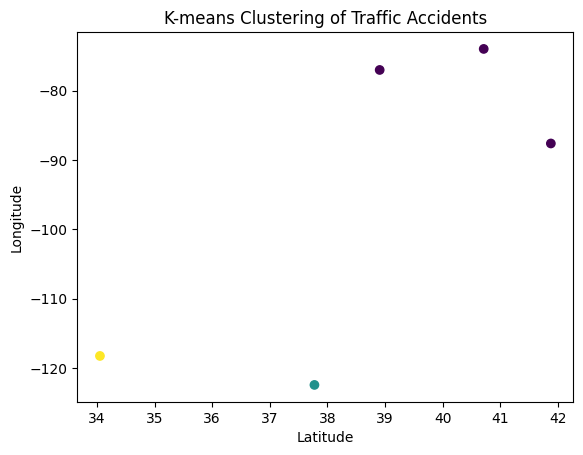

In [211]:
### clustering sample 

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'accidents_df'
# Replace 'accidents_df' with the actual name of your DataFrame

# Example DataFrame
data = {'latitude': [40.7128, 34.0522, 41.8781, 37.7749, 38.9072],
        'longitude': [-74.0060, -118.2437, -87.6298, -122.4194, -77.0370],
        'severity': [1, 2, 1, 3, 2],
        'temperature': [25, 28, 22, 24, 26]}
accidents_df = pd.DataFrame(data)

# Select relevant features for clustering
features = ['latitude', 'longitude', 'severity', 'temperature']
X = accidents_df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters (you may need to experiment with this)
n_clusters = 3

# Fit K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
accidents_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters (for 2D features like latitude and longitude)
plt.scatter(accidents_df['latitude'], accidents_df['longitude'], c=accidents_df['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering of Traffic Accidents')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()
